In [1]:
!pip install transformers
!pip install torchvision
!pip install datasets
!pip install ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git

!pip install Pillow==9.0.0 # Sometimes BLIP has compatibility issues with newer PIL versions, safer to specify
!pip install accelerate # Often needed for Hugging Face models


  Preparing metadata (setup.py) ... done


In [2]:
import os
import torch
import clip
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score
from torchvision import transforms
from transformers import BlipProcessor, BlipForConditionalGeneration


In [3]:
#mount to read/write other files in folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("parthplc/facebook-hateful-meme-dataset")
print("Dataset path:", path)

# Load the training JSON
df = pd.read_json(path + '/data/train.jsonl', lines=True)
df.head()


Dataset path: /kaggle/input/facebook-hateful-meme-dataset


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


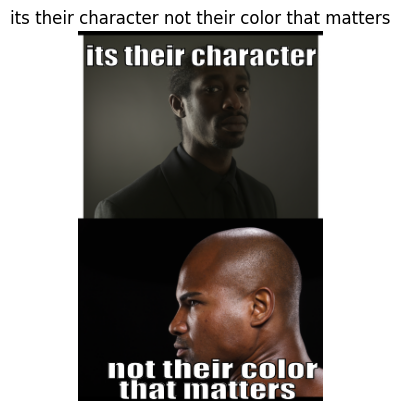

Label: Not Hateful


In [5]:
sample = df.iloc[0]

image_path = os.path.join(path, "data", sample["img"])
img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.title(sample["text"])
plt.show()

print("Label:", "Hateful" if sample["label"] == 1 else "Not Hateful")


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False

# Choose text model
text_model_name = "xlm-roberta-base"


tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model = AutoModel.from_pretrained(text_model_name).to(device)
text_model.eval() #sets model to inference mode (disables dropout).

# Load BLIP Processor and Model for Captioning
print("Loading BLIP captioning model...")
caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
caption_model.eval() # Set to evaluation mode as we are only using it for inference (generating captions)
for p in caption_model.parameters(): # Freeze BLIP captioning model parameters
    p.requires_grad = False
print("BLIP captioning model loaded.")


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 165MiB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP captioning model...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

BLIP captioning model loaded.


In [7]:
all_data = []

for _, row in df.iterrows():
    image_path = os.path.join(path, "data", row["img"])
    # Open the image ensuring it's in RGB format for BLIP
    raw_image = Image.open(image_path).convert("RGB")

    # Preprocess the image for CLIP
    image = preprocess(raw_image)

    # Generate caption using BLIP model
    # Inputs for BLIP processor
    inputs_blip = caption_processor(images=raw_image, return_tensors="pt").to(device)

    # Generate the caption (max_new_tokens controls caption length)
    # A warning might appear about max_length, you can ignore it or explicitly set max_new_tokens
    generated_ids = caption_model.generate(**inputs_blip, max_new_tokens=50) # Increased max_new_tokens for potentially longer captions
    generated_caption = caption_processor.decode(generated_ids[0], skip_special_tokens=True)

    # Original text from the dataset
    original_text = row["text"]

    # Combine original text with generated caption
    # Using a clear separator to distinguish original text from caption
    text = f"{original_text} [CAPTION] {generated_caption}"
    label = row["label"]
    all_data.append((image, text, label))

print("Total samples:", len(all_data))


Total samples: 8500


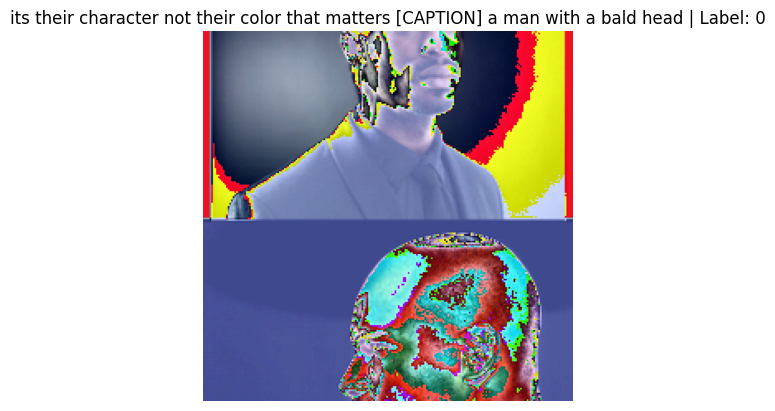

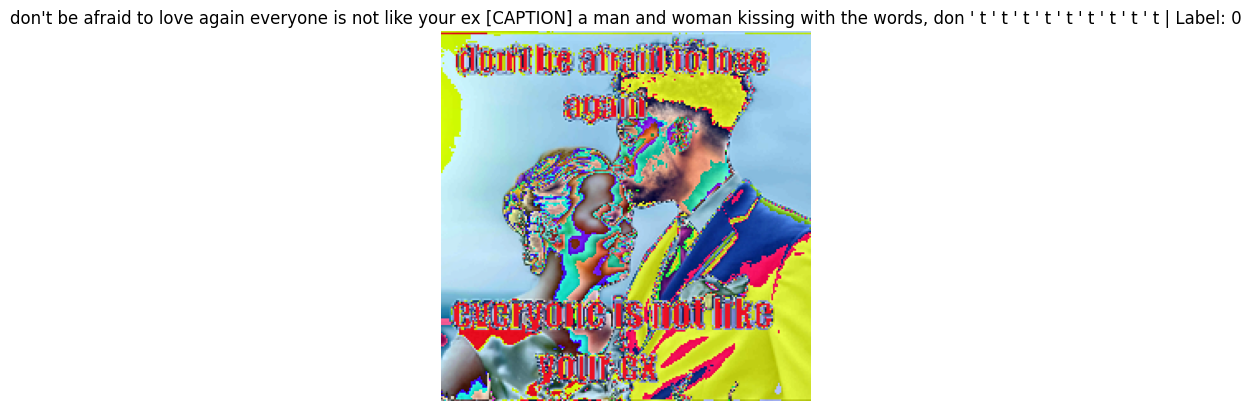

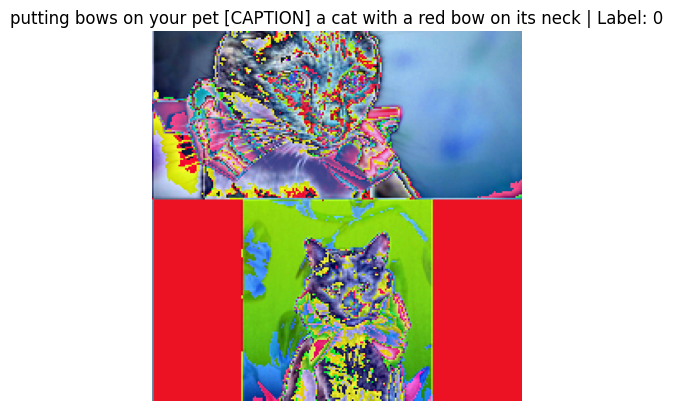

In [8]:
for i in range(3):
    image, text, label = all_data[i]
    plt.imshow(transforms.ToPILImage()(image))
    plt.axis('off')
    plt.title(f"{text} | Label: {label}")
    plt.show()


In [9]:
train_indices, val_indices = train_test_split(range(len(all_data)), test_size=0.2, random_state=42)

train_data = [all_data[i] for i in train_indices]
val_data = [all_data[i] for i in val_indices]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

print("Train size:", len(train_data))
print("Validation size:", len(val_data))


Train size: 6800
Validation size: 1700


In [10]:
image_dim = clip_model.visual.output_dim
text_dim = text_model.config.hidden_size

linear_layer = torch.nn.Linear(image_dim + text_dim, 1).to(device)
optimizer = torch.optim.Adam(list(linear_layer.parameters()) + list(text_model.parameters()), lr=1e-4)
labels = df['label'].tolist()
pos_count = sum(labels)
neg_count = len(labels) - pos_count
pos_weight = torch.tensor([neg_count / pos_count]).to(device)

loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [11]:
images, texts, labels = next(iter(train_loader))

images = images.to(device)
labels = labels.float().to(device)

with torch.no_grad():
    image_feats = clip_model.encode_image(images)

print("Image features shape:", image_feats.shape)

tokenized = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=256) # pt is pytorch tensor, tf for tensorflow tensor
tokenized = {k: v.to(device) for k, v in tokenized.items()}
text_output = text_model(**tokenized)
text_feats = text_output.last_hidden_state[:, 0, :]

print("Text features shape:", text_feats.shape)

combined_feats = torch.cat([image_feats, text_feats], dim=1)
print("Combined features shape:", combined_feats.shape)


Image features shape: torch.Size([32, 512])
Text features shape: torch.Size([32, 768])
Combined features shape: torch.Size([32, 1280])


In [12]:
# Train
for epoch in range(3):
    total_loss = 0
    linear_layer.train()
    text_model.train()

    for images, texts, labels in train_loader:
        images = images.to(device)
        labels = labels.float().to(device)

        with torch.no_grad():
            image_feats = clip_model.encode_image(images)

        tokenized = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=256)
        tokenized = {k: v.to(device) for k, v in tokenized.items()}
        text_feats = text_model(**tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)).last_hidden_state[:, 0, :]

        combined = torch.cat([image_feats, text_feats], dim=1)
        logits = linear_layer(combined).squeeze()

        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 - Loss: 0.8832
Epoch 2 - Loss: 0.8638
Epoch 3 - Loss: 0.8527


In [13]:
#Test
linear_layer.eval()
text_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, texts, labels in val_loader:
        images = images.to(device)

        image_feats = clip_model.encode_image(images)

        tokenized = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=256)
        tokenized = {k: v.to(device) for k, v in tokenized.items()}
        text_feats = text_model(**tokenized).last_hidden_state[:, 0, :]

        combined = torch.cat([image_feats, text_feats], dim=1)
        logits = linear_layer(combined).squeeze()
        preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {acc:.4f}")


Validation Accuracy: 0.6847


In [14]:
# "bert-base-uncased" Validation Accuracy: 0.7035

In [15]:
# "xlm-roberta-base"

In [ ]:
# Load test data JSONL
test_df = pd.read_json(path + '/data/test.jsonl', lines=True)

test_data = []
for _, row in test_df.iterrows():
    image_path = os.path.join(path, "data", row["img"])
    raw_image = Image.open(image_path).convert("RGB")
    image = preprocess(raw_image) # For CLIP

    # Generate caption using BLIP model
    inputs_blip = caption_processor(images=raw_image, return_tensors="pt").to(device)
    generated_ids = caption_model.generate(**inputs_blip, max_new_tokens=50)
    generated_caption = caption_processor.decode(generated_ids[0], skip_special_tokens=True)

    original_text = row["text"]
    text = f"{original_text} [CAPTION] {generated_caption}"
    # test set may not have labels, so handle accordingly
    label = row.get("label", -1)  # -1 if label not present
    test_data.append((image, text, label))

test_loader = DataLoader(test_data, batch_size=32)

linear_layer.eval()
text_model.eval()

all_preds = []
all_labels = []
all_probs = []  #rutvij added to collect soft probs

with torch.no_grad():
    for images, texts, labels in test_loader:
        images = images.to(device)

        image_feats = clip_model.encode_image(images)

        tokenized = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=77)
        tokenized = {k: v.to(device) for k, v in tokenized.items()}
        text_feats = text_model(**tokenized).last_hidden_state[:, 0, :]

        combined = torch.cat([image_feats, text_feats], dim=1)
        logits = linear_layer(combined).squeeze()
        preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()

        all_preds.extend(preds)

        #rutvij added to collect soft probs
        batch_probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(batch_probs)

        if labels[0] != -1:  # if labels exist
            all_labels.extend(labels.numpy())

if len(all_labels) > 0:
    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
else:
    print("Test predictions:", all_preds)


## Save Outputs

In [ ]:
import numpy as np
import os

output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

if len(all_labels) > 0:
    np.save(os.path.join(output_dir, "y_true_xlmr.npy"), np.array(all_labels))
    np.save(os.path.join(output_dir, "y_probs_xlmr.npy"), np.array(all_probs))
else:
    np.save(os.path.join(output_dir, "y_preds_xlmr.npy"), np.array(all_preds))
    np.save(os.path.join(output_dir, "y_probs_xlmr.npy"), np.array(all_probs))
